In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, freqz

In [89]:
r_1 = 10 * 10**3
r_2 = 2 * r_1
c_1 = 100 * 10**-9
c_2 = c_1

K = 2

w = 1 / np.sqrt(r_1 * r_2 * c_1 * c_2)
fc = w / (2 * np.pi)
Q_inv = np.sqrt((r_2*c_2)/(r_1*c_1)) + np.sqrt((r_1*c_2)/(r_2*c_1)) + (1 - K) * np.sqrt((r_1*c_1)/(r_2*c_2))
Q = 1 / (Q_inv)

print("fc = ", fc)
print("Q = ", Q)

fc =  112.53953951963825
Q =  0.7071067811865474


In [90]:
df = pd.read_csv("Freq Resp.csv")
df["Gain"] = df["V_out [V]"] / df["V_in [V]"]
df["Gain [dB]"] = 20 * np.log10(df["Gain"])
df["Gain"] = df["Gain"].round(2)
df["Gain [dB]"] = df["Gain [dB]"].round(2)
df.to_csv("Processed Freq Resp.csv", index=False)

df

,Frequency [Hz],V_in [V],V_out [V],Gain,Gain [dB]
0,1,1.03,2.11,2.05,6.23
1,2,1.05,2.13,2.03,6.14
2,4,1.05,2.11,2.01,6.06
3,8,1.05,2.04,1.94,5.77
4,16,1.05,2.04,1.94,5.77
5,20,1.05,2.11,2.01,6.06
6,30,1.05,2.11,2.01,6.06
7,40,1.05,2.11,2.01,6.06
8,50,1.05,2.09,1.99,5.98
9,60,1.05,2.05,1.95,5.81


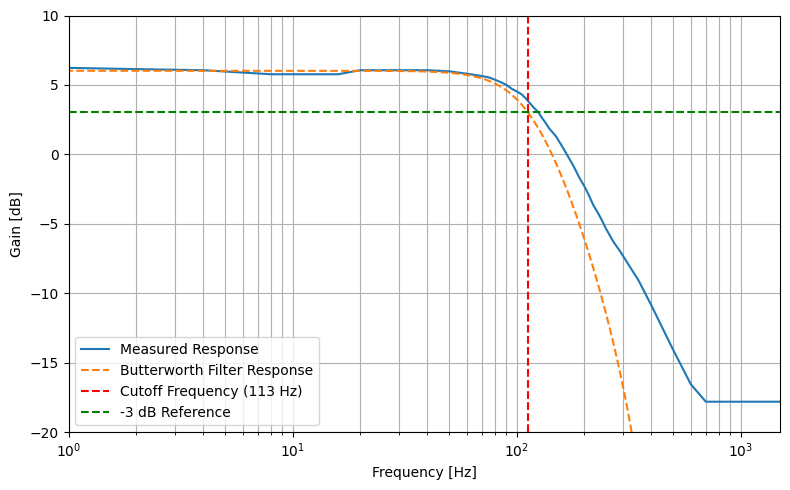

In [91]:
order = 2   # Filter order
fs = 1000   # Sampling frequency in Hz

# Normalize the cutoff frequency (relative to Nyquist frequency)
cutoff_norm = fc / (fs / 2)

# Design the Butterworth filter
b, a = butter(order, cutoff_norm, btype='low', analog=False)

# Compute the frequency response
w, h = freqz(b, a, worN=1000)
h = 2 * h # Gain of 2

# Convert from rad/sample to Hz: f = (w / (2π)) * fs
freqs = w * fs / (2 * np.pi)

plt.figure(figsize=(8, 5))
plt.semilogx(df["Frequency [Hz]"], df["Gain [dB]"], label="Measured Response")
plt.semilogx(freqs, 20 * np.log10(np.abs(h)), label="Butterworth Filter Response", linestyle='dashed')
plt.axvline(fc, color='red', linestyle='--', label=f'Cutoff Frequency ({round(fc)} Hz)')
plt.axhline(20 * np.log10(2) - 3, color='green', linestyle='--', label='-3 dB Reference')
plt.xlabel("Frequency [Hz]")
plt.ylabel("Gain [dB]")
plt.xlim(1, 1500)
plt.ylim(-20, 10)
plt.legend()
plt.grid(which='both')
plt.tight_layout()
plt.savefig("assets/frequency_response.png")

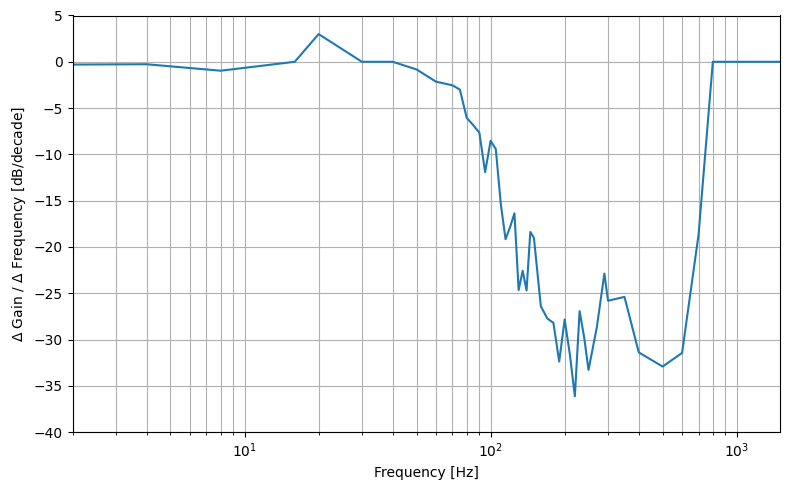

In [92]:
# Compute frequency differences
df["delta_gain"] = df["Gain [dB]"].diff()
df["delta_freq_log2"] = np.log2(df["Frequency [Hz]"]).diff()
df["delta_freq_log10"] = np.log10(df["Frequency [Hz]"]).diff()

# Compute roll-off rates
df["rolloff_dB_per_octave"] = df["delta_gain"] / df["delta_freq_log2"]
df["rolloff_dB_per_decade"] = df["rolloff_dB_per_octave"] * (10 / np.log2(10))
df["freq_derivative_dB_per_decade"] = df["delta_gain"] / df["delta_freq_log10"]

# Plot the derivative in dB/decade
plt.figure(figsize=(8, 5))
plt.semilogx(df["Frequency [Hz]"], df["freq_derivative_dB_per_decade"], label="Derivative [dB/decade]")
plt.xlabel("Frequency [Hz]")
plt.ylabel("$\\Delta$ Gain / $\\Delta$ Frequency [dB/decade]")
plt.xlim(2, 1500)
plt.ylim(-40, 5)
plt.grid(True, which="both")
plt.tight_layout()
plt.savefig("assets/Roll-off Rate.png")

Figure saved as assets/LTSpice Roll-off Rate.png


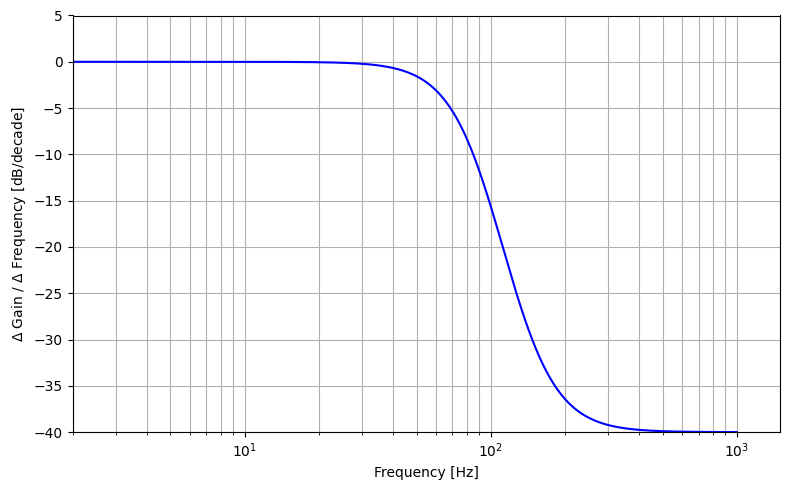

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import re

# Function to parse the data file
def parse_data(file_path):
    frequencies = []
    gains = []

    with open(file_path, 'r') as file:
        next(file)  # Skip the header
        for line in file:
            parts = line.split()
            if len(parts) < 2:
                continue
            
            freq = float(parts[0])
            match = re.search(r'\((.*?)dB', parts[1])
            if match:
                gain = float(match.group(1))  # Extract gain in dB
                frequencies.append(freq)
                gains.append(gain)

    return np.array(frequencies), np.array(gains)

# Function to compute the roll-off rate in dB/decade
def compute_roll_off_dB_per_decade(frequencies, gains):
    log_freq = np.log10(frequencies)
    dG = np.diff(gains)
    dLogF = np.diff(log_freq)  # Change in log10(F)
    roll_off = dG / dLogF  # dB per decade
    return frequencies[:-1], roll_off  # Match length of frequency array

# Function to plot and save the roll-off rate figure
def plot_and_save_roll_off(frequencies, roll_off, output_file="roll_off_plot.png"):
    plt.figure(figsize=(8, 5))
    plt.plot(frequencies, roll_off, label="Roll-Off Rate [dB/decade]", color='b')
    plt.xscale("log")  # Log scale for frequency
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("$\\Delta$ Gain / $\\Delta$ Frequency [dB/decade]")
    plt.xlim(2, 1500)
    plt.ylim(-40, 5)
    plt.grid(True, which="both")
    
    # Save the figure
    plt.tight_layout()
    plt.savefig(output_file)  
    print(f"Figure saved as {output_file}")
    
    plt.show()  # Display the plot

# Main execution
file_path = "Draft1.txt"  # Change this to your actual file path
output_file = "assets/LTSpice Roll-off Rate.png"  # Output file name

frequencies, gains = parse_data(file_path)
freqs_for_plot, roll_off_rates = compute_roll_off_dB_per_decade(frequencies, gains)
plot_and_save_roll_off(freqs_for_plot, roll_off_rates, output_file)


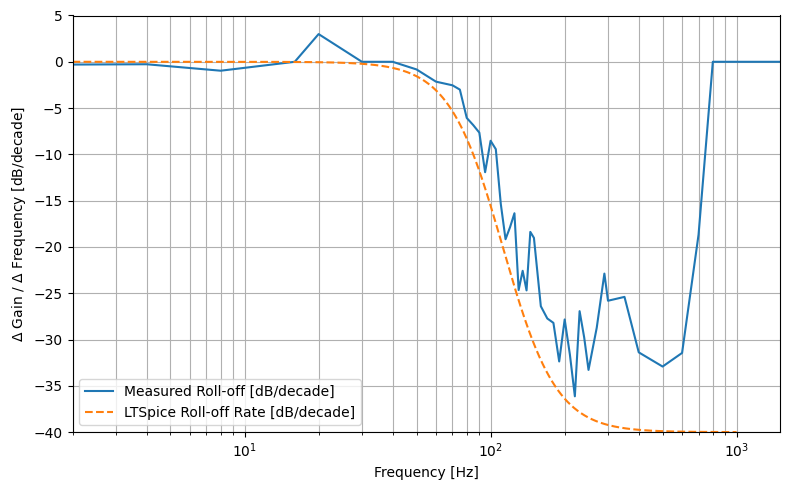

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# Load and process CSV data
df = pd.read_csv("Freq Resp.csv")
df["Gain"] = df["V_out [V]"] / df["V_in [V]"]
df["Gain [dB]"] = 20 * np.log10(df["Gain"])
df["Gain"] = df["Gain"].round(2)
df["Gain [dB]"] = df["Gain [dB]"].round(2)

# Compute frequency differences and roll-off rates
df["delta_gain"] = df["Gain [dB]"].diff()
df["delta_freq_log10"] = np.log10(df["Frequency [Hz]"]).diff()
df["freq_derivative_dB_per_decade"] = df["delta_gain"] / df["delta_freq_log10"]

# Function to parse the Draft1.txt file
def parse_data(file_path):
    frequencies = []
    gains = []

    with open(file_path, 'r') as file:
        next(file)  # Skip the header
        for line in file:
            parts = line.split()
            if len(parts) < 2:
                continue
            
            freq = float(parts[0])
            match = re.search(r'\((.*?)dB', parts[1])
            if match:
                gain = float(match.group(1))  # Extract gain in dB
                frequencies.append(freq)
                gains.append(gain)

    return np.array(frequencies), np.array(gains)

# Function to compute the roll-off rate in dB/decade
def compute_roll_off_dB_per_decade(frequencies, gains):
    log_freq = np.log10(frequencies)
    dG = np.diff(gains)
    dLogF = np.diff(log_freq)  # Change in log10(F)
    roll_off = dG / dLogF  # dB per decade
    return frequencies[:-1], roll_off  # Match length of frequency array

# Load and process Draft1.txt data
file_path = "Draft1.txt"
frequencies, gains = parse_data(file_path)
freqs_for_plot, roll_off_rates = compute_roll_off_dB_per_decade(frequencies, gains)

# Create a combined figure with subplots
plt.figure(figsize=(8, 5))

# First subplot: DataFrame roll-off rate
plt.semilogx(df["Frequency [Hz]"], df["freq_derivative_dB_per_decade"], label="Measured Roll-off [dB/decade]")

# Second subplot: Parsed Draft1.txt roll-off rate
plt.semilogx(freqs_for_plot, roll_off_rates, label="LTSpice Roll-off Rate [dB/decade]", linestyle="dashed")

# Formatting
plt.xlabel("Frequency [Hz]")
plt.ylabel("$\\Delta$ Gain / $\\Delta$ Frequency [dB/decade]")
plt.xlim(2, 1500)
plt.ylim(-40, 5)
plt.legend()
plt.grid(True, which="both")

# Save and show plot
plt.tight_layout()
plt.savefig("assets/Combined Roll-off Rate.png")
plt.show()